In [42]:
# Importing Packages

import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import chardet
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols, logit 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import heapq
import re
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans 
import plotnine
from plotnine import *
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from sklearn.decomposition import PCA
import copy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.tree import export_graphviz
import pydot
import graphviz
from graphviz import Source
from IPython.display import display
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

In [2]:
# Importing processed data into notebook

sourcepath = 'D:\Work\Research\Dropbox\Machine Learning\Side Projects\Employee Churn IBM\employee_churn_prediction_ibm'
datapath = os.path.join(sourcepath, 'data','processed','IBM_HR_Data_Cleaned.csv')

IBMData = pd.read_csv(datapath)

In [3]:
# Plotting data head 
# IBMData.head(n=5) 

In [4]:
# Dropping irrelevant variables

IBMData.drop(['EmployeeNumber'], axis = 1, inplace = True) # Drop this columns because it represents unique identifier for each worker and each worker does not appear more than once in the data

In [5]:
# Now check that variables have the correct data type
# IBMData.dtypes 

In [6]:
## Keep some variables which are essentially categorial in a numeric format
# This would keep the number of categorical variables less, because RF classifiers can only handle numeric data

numvars = ['Age','DailyRate','DistanceFromHome','HourlyRate','MonthlyIncome','MonthlyRate','NumCompaniesWorked', 
          'PercentSalaryHike','PerformanceRating','TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany',
          'YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager']
newnumvars = ['Education','EnvironmentSatisfaction','JobInvolvement','JobLevel','JobSatisfaction','PerformanceRating',
              'RelationshipSatisfaction','StockOptionLevel','WorkLifeBalance']
catvars = [item for item in IBMData.columns.to_list() if item not in numvars and item not in newnumvars and item != 'Attrition']

In [7]:
# Now convert the newnumvars into float data
IBMData[newnumvars] = IBMData[newnumvars].apply(pd.to_numeric, downcast = 'float', axis = 1)
IBMData[catvars] = IBMData[catvars].astype('category')

In [8]:
# Now rename levels of some categorical variables

IBMData['BusinessTravel'].cat.rename_categories(
        {'Travel_Rarely':'Rare','Travel_Frequently':'Freq','Non-Travel':'No'}, inplace = True)
IBMData['Department'].cat.rename_categories(
    {'Research & Development':'R&D','Sales':'Sales','Human Resources':'HR'}, inplace = True)
IBMData['EducationField'].cat.rename_categories(
    {'Life Sciences':'LifeSc','Technical Degree':'Technical','Human Resources':'EducHR'}, inplace = True)
IBMData['JobRole'].cat.rename_categories(
    {'Sales Executive':'SalexExec','Research Scientist':'Scientist','Laboratory Technician':'LabTech',
    'Manufacturing Director':'ManufDir','Healthcare Representative':'HealthRep','Sales Representative':'SalesRep',
    'Research Director':'ResDir','Human Resources':'RoleHR'}, inplace = True)

In [9]:
# Now recategorize the Attrition variable from object to int 

exit_status_map = {'Yes':1, 'No':0}
IBMData['Attrition'] = IBMData['Attrition'].map(exit_status_map)

In [10]:
# Now one hot encoding the data
# Make a copy of the old dataset and generate dummies in the new data copy

IBMDataNew = IBMData.copy(deep = True)
IBMDataNewLabel = IBMDataNew['Attrition'].copy(deep = True)
IBMDataNew.drop(['Attrition'], inplace = True, axis = 1)
IBMDataNew = pd.get_dummies(IBMDataNew)

In [11]:
## Now check the variable names in the new data and find out the number of variables (including one-hot encoded dummies)

print('Target Variable is:',IBMDataNewLabel.name)
print()
print('Predictor Variables are:', IBMDataNew.columns.to_list())
print()
print('Number of Observations in Target: {}'.format(len(IBMDataNewLabel)))
print()
print('Shape of Predictor Variables Frame: {}'.format(IBMDataNew.shape))

Target Variable is: Attrition

Predictor Variables are: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'BusinessTravel_No', 'BusinessTravel_Freq', 'BusinessTravel_Rare', 'Department_HR', 'Department_R&D', 'Department_Sales', 'EducationField_EducHR', 'EducationField_LifeSc', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical', 'Gender_Female', 'Gender_Male', 'JobRole_HealthRep', 'JobRole_RoleHR', 'JobRole_LabTech', 'JobRole_Manager', 'JobRole_ManufDir', 'JobRole_ResDir', 'JobRole_Scientist', 'JobRole_SalexExec', 'JobRole_SalesRep', 'MaritalStatu

In [12]:
# Convert the data to numpy arrays

feature_list = IBMDataNew.columns.to_list()
IBMDataNewLabel = np.array(IBMDataNewLabel)
IBMDataNew = np.array(IBMDataNew)

In [13]:
## Now split the data into training and test sets.

Xtrain, Xtest, Ytrain, Ytest = train_test_split(IBMDataNew, IBMDataNewLabel, test_size = 0.25, random_state = 50)

# Print the shapes of the new datasets and their types
print('Shapes of Xtrain, Xtest, Ytrain, Ytest respectively are:', Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)
print('Data Types are:', type(Xtrain), type(Xtest), type(Ytrain), type(Ytest))

# Now print the fraction of target labels in the two sets
print('Counts of Retention and Exits in Train and Test Labels respectively:')
print(np.unique(Ytrain, return_counts = True), np.unique(Ytest, return_counts = True))


Shapes of Xtrain, Xtest, Ytrain, Ytest respectively are: (1102, 51) (368, 51) (1102,) (368,)
Data Types are: <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Counts of Retention and Exits in Train and Test Labels respectively:
(array([0, 1], dtype=int64), array([925, 177])) (array([0, 1], dtype=int64), array([308,  60]))


In [14]:
## First construct the classifier

seed = 50
rf_classifier = RandomForestClassifier(n_estimators = 150, # Number of individual decision trees to estimate
                                      criterion = 'entropy', 
                                      max_features = 'auto', # Selects a certain number of features at each node to choose upon
                                      bootstrap = True, 
                                      oob_score = True, 
                                      n_jobs = 1, 
                                      random_state = seed)

In [15]:
# Now fit the classifier to the training data 

rf_fit = rf_classifier.fit(Xtrain, Ytrain)

In [16]:
# Now predict the target in the test data

Ypred = rf_classifier.predict(Xtest)

In [17]:
# Now check for some of the basic metrics in the preidctions:

print('Precision of Prediction: {:2.3%}'.format(precision_score(Ytest, Ypred)))
print('Accuracy of Prediction: {:2.3%}'.format(accuracy_score(Ytest, Ypred)))
print('Recall of Prediction: {:2.3%}'.format(recall_score(Ytest, Ypred)))
print('Confusion Matrix of Prediction:\n', confusion_matrix(Ytest, Ypred))
print('F1 Score of Prediction: {:1.3}'.format(f1_score(Ytest, Ypred)))


Precision of Prediction: 66.667%
Accuracy of Prediction: 84.511%
Recall of Prediction: 10.000%
Confusion Matrix of Prediction:
 [[305   3]
 [ 54   6]]
F1 Score of Prediction: 0.174


ROC Score for the Training Set: 1.0
ROC Score for the Test Set: 0.801
Recall Baseline: 1.0 Test: 0.1 Train: 1.0
Precision Baseline: 0.16 Test: 0.67 Train: 1.0
Roc Baseline: 0.5 Test: 0.8 Train: 1.0


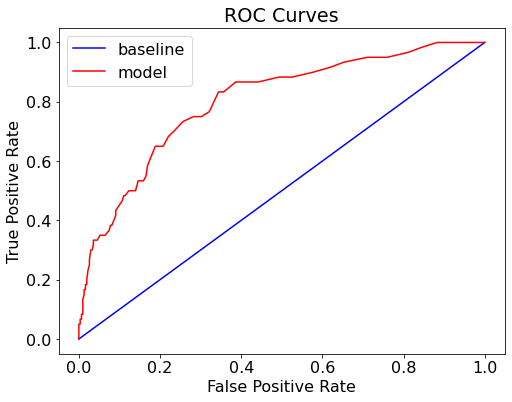

In [18]:
# Now compute the Receiver Operating Characteristic Score (ROC) and the ROC Curve

train_probs = rf_classifier.predict_proba(Xtrain)[:,1] # The second columns gives the predicted probability that the observations belongs to the treated class
test_probs = rf_classifier.predict_proba(Xtest)[:,1]
Ypred_train = rf_classifier.predict(Xtrain)

print('ROC Score for the Training Set: {:1.3}'.format(roc_auc_score(Ytrain, train_probs)))
print('ROC Score for the Test Set: {:1.3}'.format(roc_auc_score(Ytest, test_probs)))

# Now plot the ROC AUC Curve 
def evaluate_model(Ypred, test_probs, Ytrain_pred, train_probs):
    
    baseline = {}
    baseline['recall'] = recall_score(Ytest, [1 for _ in range(len(Ytest))])
    baseline['precision'] = precision_score(Ytest, [1 for _ in range(len(Ytest))])
    baseline['roc'] = 0.5
    
    results = {}
    results['recall'] = recall_score(Ytest, Ypred)
    results['precision'] = precision_score(Ytest, Ypred)
    results['roc'] = roc_auc_score(Ytest, test_probs)
    
    train_results = {}
    train_results['recall'] = recall_score(Ytrain, Ypred_train)
    train_results['precision'] = precision_score(Ytrain, Ypred_train)
    train_results['roc'] = roc_auc_score(Ytrain, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
        
    # Calculate FPR and TPR
    base_fpr, base_tpr, _ = roc_curve(Ytest, [1 for _ in range(len(Ytest))])
    model_fpr, model_tpr, _ = roc_curve(Ytest, test_probs)
       
    plt.figure(figsize = (8,6))
    plt.rcParams['font.size'] = 16        
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();
        
evaluate_model(Ypred, test_probs, Ypred_train, train_probs)        
                 
                 


Variable: MonthlyIncome                       Importance: 0.07615240586047671
Variable: Age                                 Importance: 0.053677688214925315
Variable: DailyRate                           Importance: 0.05314109098074694
Variable: DistanceFromHome                    Importance: 0.05049415999023602
Variable: TotalWorkingYears                   Importance: 0.04769191996828714
Variable: MonthlyRate                         Importance: 0.04741684134887322
Variable: HourlyRate                          Importance: 0.04513383797737514
Variable: YearsAtCompany                      Importance: 0.0440285787579567
Variable: PercentSalaryHike                   Importance: 0.03428745270705197
Variable: NumCompaniesWorked                  Importance: 0.03353966801391423
Variable: OverTime_No                         Importance: 0.03193041534916602
Variable: YearsInCurrentRole                  Importance: 0.030511212515932484
Variable: OverTime_Yes                        Importance: 0.029

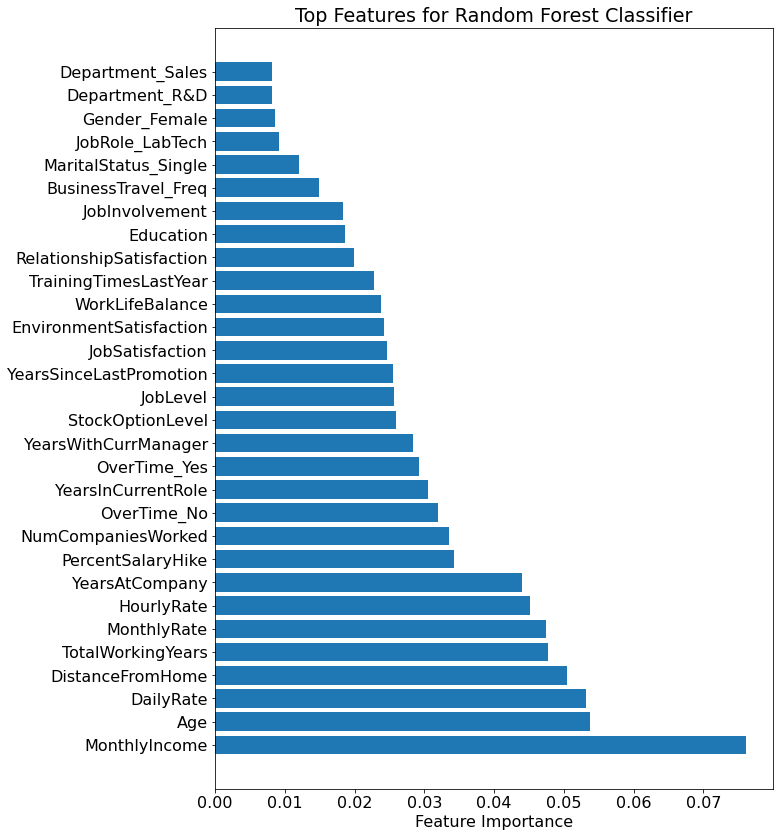

In [19]:
## Now looking at the importance of the features and sorting them by their importance

feature_importances = list(zip(feature_list, rf_classifier.feature_importances_))
# Now sort the features by their importance
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];

# Visualizing top 10 features
numfeatures = 30
feature_names = [i[0] for i in feature_importances_ranked[:numfeatures]]
y_ticks = np.arange(0, len(feature_names))
x_axis = [i[1] for i in feature_importances_ranked[:numfeatures]]

plt.figure(figsize = (10,14))
plt.barh(feature_names, x_axis)
plt.title('Top Features for Random Forest Classifier')
plt.xlabel('Feature Importance')
plt.show();

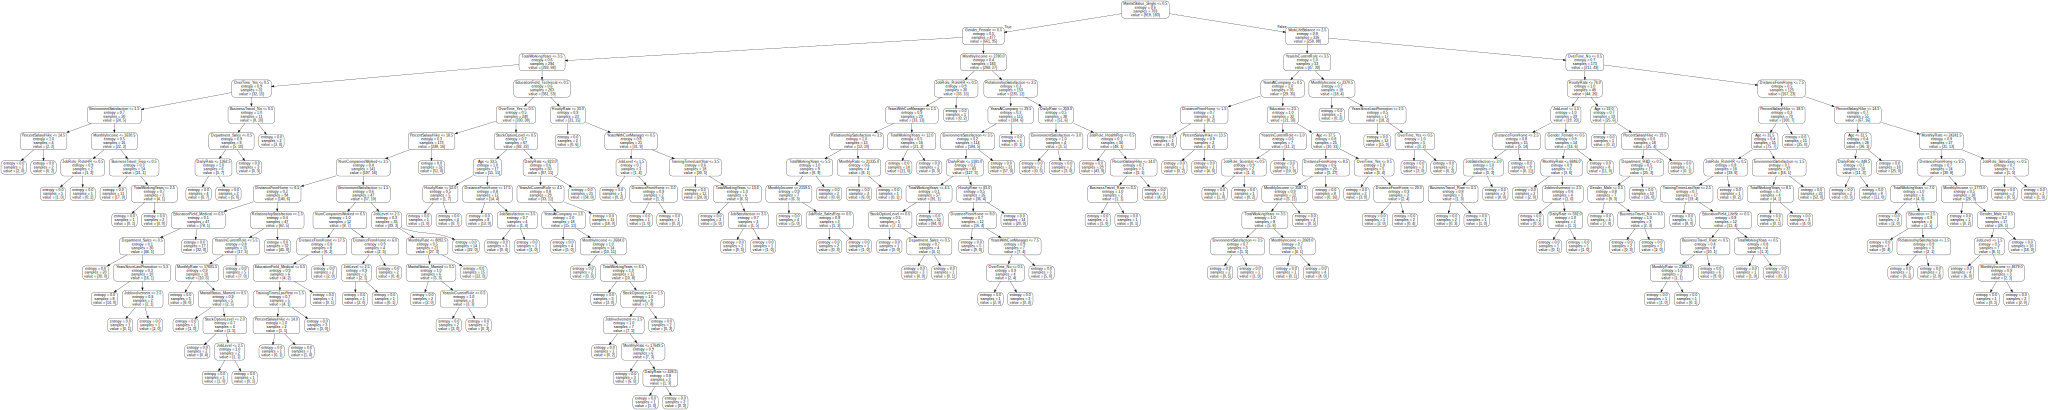

In [30]:
# Visualizing a single decision tree

tree = rf_classifier.estimators_[5] # Pull out one tree
# Export the image to a dot file
outfile = os.path.join(sourcepath, "reports", "figures", "tree.dot")
outgraph = os.path.join(sourcepath, "reports", "figures", "tree.png")
export_graphviz(tree, out_file = outfile, feature_names = feature_list, rounded = True, precision = 1)
with open(outfile) as f:
    dot_graph = f.read()
g = graphviz.Source(dot_graph)
display(g)

In [43]:
## Now we tune the hyperparameters of the Random Forest Classifier

# First look at the parameters currently being used
print('Parameters currently in use:\n')
pprint(rf_classifier.get_params())

# Now create a grid of some of the more important parameters
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 50)]
max_features = ['auto', 'log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 4, 10]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
               'bootstrap': bootstrap}

rf_classifier_new = RandomForestClassifier(oob_score = True)
rf_optimized = RandomizedSearchCV(estimator = rf_classifier_new, 
                                 param_distributions = random_grid,
                                 n_iter = 100, cv = 3, 
                                 verbose = 0, random_state = seed, 
                                 scoring = make_scorer(recall_score))
rf_optimized.fit(Xtrain, Ytrain)

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': 1,
 'oob_score': True,
 'random_state': 50,
 'verbose': 0,
 'warm_start': False}


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(oob_score=True),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'log2'],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 11,
                                                           11, 11, 11, 11, 11,
                                                           11, 11, 11, 11, 11,
                                                           11, 12, 12, 12, 12, ...],
                                        'min_samples_le

In [44]:
rf_optimized.best_params_

{'n_estimators': 565,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 46,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [48]:
Ypred_optimized = rf_optimized.best_estimator_.predict(Xtest)

print('Precision of Prediction: {:2.3%}'.format(precision_score(Ytest, Ypred_optimized)))
print('Accuracy of Prediction: {:2.3%}'.format(accuracy_score(Ytest, Ypred_optimized)))
print('Recall of Prediction: {:2.3%}'.format(recall_score(Ytest, Ypred_optimized)))
print('Confusion Matrix of Prediction:\n', confusion_matrix(Ytest, Ypred_optimized))
print('F1 Score of Prediction: {:1.3}'.format(f1_score(Ytest, Ypred_optimized)))

Precision of Prediction: 75.000%
Accuracy of Prediction: 84.783%
Recall of Prediction: 10.000%
Confusion Matrix of Prediction:
 [[306   2]
 [ 54   6]]
F1 Score of Prediction: 0.176


In [49]:
# Now look at the depth and nodes of the trees used on average
n_nodes = []
max_depths = []
for ind_tree in rf_optimized.best_estimator_.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print('Average number of nodes of the trees used: {}'.format(int(np.mean(n_nodes))))
print('Average maximum depths of the trees used: {}'.format(int(np.mean(max_depths))))

Average number of nodes of the trees used: 91
Average maximum depths of the trees used: 10


ROC Score for the Training Set: 0.986
ROC Score for the Test Set: 0.834
Recall Baseline: 1.0 Test: 0.1 Train: 1.0
Precision Baseline: 0.16 Test: 0.67 Train: 1.0
Roc Baseline: 0.5 Test: 0.83 Train: 0.99


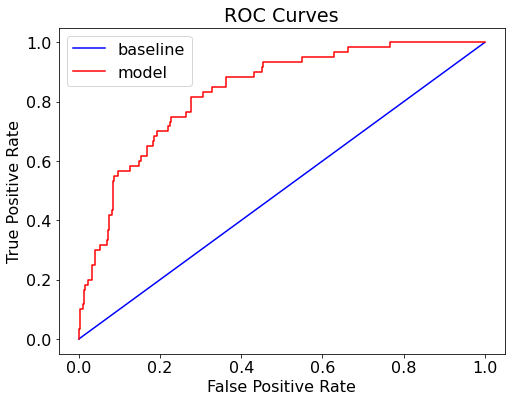

In [51]:
## Now we can see the ROC_AUC Curve again

train_probs_best = rf_optimized.best_estimator_.predict_proba(Xtrain)[:,1] # The second columns gives the predicted probability that the observations belongs to the treated class
test_probs_best = rf_optimized.best_estimator_.predict_proba(Xtest)[:,1]
Ypred_train_best = rf_optimized.best_estimator_.predict(Xtrain)

print('ROC Score for the Training Set: {:1.3}'.format(roc_auc_score(Ytrain, train_probs_best)))
print('ROC Score for the Test Set: {:1.3}'.format(roc_auc_score(Ytest, test_probs_best)))

  
evaluate_model(Ypred, test_probs_best, Ypred_train_best, train_probs_best)        
                 